## References:
Part of code taken from: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py

In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Get data and define features

In [5]:
#Get raw documents:
train, test, labels = getData()
train, _X, labels, _Y = train_test_split(train, labels, test_size=0.20, random_state=42)

In [ ]:
#Convert chars to integer:
#Use a charcter tokenizer from utils
char_tokenizer = Char_tokenizer(train+test+_X)
X_train = char_tokenizer.transform(train)
X_test = char_tokenizer.transform(test)
__X = char_tokenizer.transform(_X)
#and one hot encode y:
num_of_classes = 12
y_train = get1hotY(labels, num_of_classes)
__Y = get1hotY(_Y, num_of_classes)

In [7]:
X_train.shape, X_test.shape, y_train.shape, __X.shape, __Y.shape

((26010, 452), (3000, 452), (26010, 12), (6503, 452), (6503, 12))

In [8]:
max_features = 27
# We are trying to learn the embedding on char level, the intuition behind embedding_size = number of classes
# is that I am trying to create embedding for classes.
# However I did some empericals expeiments and it turns out that increaing the number of embeddings (50,100)
# doesn't help in accuracy  
embedding_size = 13
max_len = getMaxLen(train+test)
num_classes = y_train.shape[1]

## Lets model

### 1. Original model from keras example with embedding layer at the start

In [34]:
def originalModel(max_features, embedding_size, maxlen, num_classes):
    
    kernel_size = 5
    filters = 64
    pool_size = 4
    lstm_output_size = 200
    
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(BatchNormalization())
    #model.add(Dropout(0.20))
    model.add(Conv1D(filters=filters, kernel_size = 4, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters, kernel_size = 5, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters, kernel_size = 6, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters, kernel_size = 8, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    return model

In [15]:
from keras.layers import *
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [35]:
model = originalModel(max_features, embedding_size, max_len, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_score])

batch_size = 256
epochs = 10
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = 30, validation_split = 0.1)

Train on 23409 samples, validate on 2601 samples
Epoch 1/30
23409/23409 [==============================] - 59s 3ms/step - loss: 2.3366 - acc: 0.1587 - f1_score: 0.2084 - val_loss: 2.3234 - val_acc: 0.1684 - val_f1_score: 0.2120
Epoch 2/30
23409/23409 [==============================] - 59s 3ms/step - loss: 2.1766 - acc: 0.2085 - f1_score: 0.2630 - val_loss: 2.0695 - val_acc: 0.2188 - val_f1_score: 0.2928
Epoch 3/30
23409/23409 [==============================] - 59s 3ms/step - loss: 1.9817 - acc: 0.2495 - f1_score: 0.3219 - val_loss: 1.9592 - val_acc: 0.2464 - val_f1_score: 0.3228
Epoch 4/30
23409/23409 [==============================] - 58s 2ms/step - loss: 1.7707 - acc: 0.3379 - f1_score: 0.3630 - val_loss: 1.6253 - val_acc: 0.4195 - val_f1_score: 0.3421
Epoch 5/30
23409/23409 [==============================] - 58s 2ms/step - loss: 1.5000 - acc: 0.4544 - f1_score: 0.3471 - val_loss: 1.4292 - val_acc: 0.4764 - val_f1_score: 0.3399
Epoch 6/30
23409/23409 [==============================] 

['acc', 'f1_score', 'loss', 'val_f1_score', 'val_acc', 'val_loss']


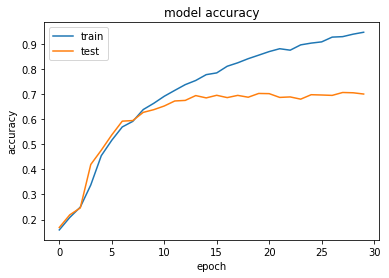

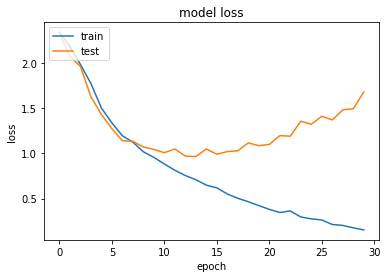

In [37]:
plotHistory(history)

### Test set accuracy

In [32]:
#loss, acc = model.evaluate(__X, __Y, verbose=0)
print(model.evaluate(__X, __Y, verbose=0))

#np.argmax(model.predict(__X),axis=1), _Y

[1.0314898933059855, 0.70013839768094865, 0.32392416223276399]


### Create the submission

In [41]:
__pred = model.predict(X_test).argmax(axis=-1)

    label  count
0       0     44
1       1    250
2       2    146
3       3    313
4       4    192
5       5    185
6       6    338
7       7    639
8       8    326
9       9    115
10     10    367
11     11     85


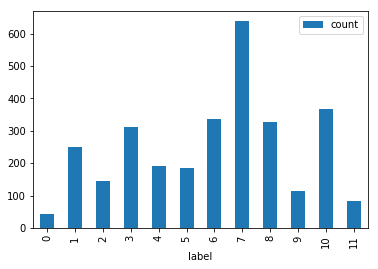

In [43]:
import pandas as pd
df = pd.DataFrame(__pred, columns=["label"]).groupby(["label"]).size().to_frame(name = 'count').reset_index()
print df
df.plot(kind="bar", x = "label")

#### Same the predictions

In [49]:
f = open('pred.txt', 'w')
for item in __pred:
  f.write("%s\n" % item)

### 2. Original model without embedding layer (One hot encoding)

In [9]:
x_train_encode = OneHotEncode().transform(X_train)
x_test_encode = OneHotEncode().transform(X_test)

In [12]:
def originalModelWithoutEmb(input_shape, num_classes):
    
    kernel_size = 5
    filters = 64
    pool_size = 4
    lstm_output_size = 200
    
    model = Sequential()
    #model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.20))
    #model.add(Conv1D(filters=filters, kernel_size = kernel_size, padding='valid', activation='relu', strides=1))
    model.add(Conv1D(filters= filters, kernel_size= kernel_size, padding='valid', activation='relu', strides=1, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filters, kernel_size = 5, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters, kernel_size = 6, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters, kernel_size = 8, padding='valid', activation='relu', strides=1))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    return model

In [13]:
model2 = originalModelWithoutEmb(x_train_encode[0].shape, num_classes)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256 
epochs = 10
history = model2.fit(x_train_encode, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Train on 23409 samples, validate on 2601 samples
Epoch 1/10
23409/23409 [==============================] - 42s 2ms/step - loss: 2.3535 - acc: 0.1582 - val_loss: 2.3456 - val_acc: 0.1499
Epoch 2/10
23409/23409 [==============================] - 42s 2ms/step - loss: 2.2555 - acc: 0.1828 - val_loss: 2.1574 - val_acc: 0.2103
Epoch 3/10
23409/23409 [==============================] - 39s 2ms/step - loss: 2.0688 - acc: 0.2314 - val_loss: 2.0158 - val_acc: 0.2280
Epoch 4/10
23409/23409 [==============================] - 41s 2ms/step - loss: 1.9423 - acc: 0.2707 - val_loss: 1.8965 - val_acc: 0.2730
Epoch 5/10
23409/23409 [==============================] - 40s 2ms/step - loss: 1.8724 - acc: 0.2845 - val_loss: 1.7777 - val_acc: 0.3337
Epoch 6/10
23409/23409 [==============================] - 36s 2ms/step - loss: 1.7020 - acc: 0.3627 - val_loss: 1.6120 - val_acc: 0.4229
Epoch 7/10
23409/23409 [==============================] - 36s 2ms/step - loss: 1.5369 - acc: 0.4371 - val_loss: 1.4957 - val_acc:

['acc', 'loss', 'val_acc', 'val_loss']


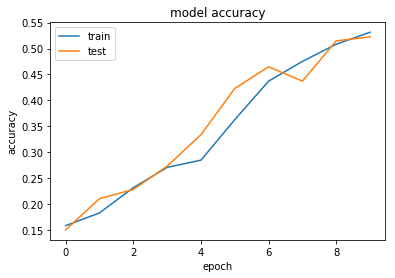

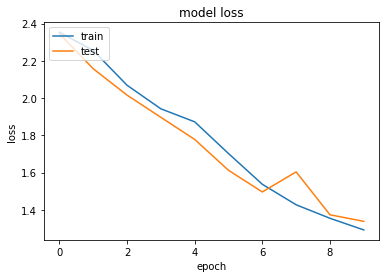

In [14]:
plotHistory(history)